In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/jr0th/github/segmentation/code/')

import skimage.io
import skimage.morphology
import skimage.segmentation

import sklearn.metrics

import os.path
import os

import numpy as np

import time

debug = True

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
gt_data_dir = '/home/jr0th/github/segmentation/experiments/GT_segmentations/'
mo_data_dir = '/home/jr0th/github/segmentation/experiments/CP/segm_CP/'

mat_dir = '/home/jr0th/github/segmentation/experiments/CP/IoU/'

path_files_test = '/home/jr0th/github/segmentation/data/BBBC022/test.txt'

err_img_out_dir = '/home/jr0th/github/segmentation/experiments/CP/error_img/'

In [3]:
with open(path_files_test) as f:
    test_files = f.read().splitlines()

In [4]:
def visualize(mat, seg_gt, seg_model):

    # get number of nuclei
    nb_nuc_gt = mat.shape[0]
    nb_nuc_model = mat.shape[1]
    
    if debug:
        print('# nuclei ground truth', nb_nuc_gt)
        print('# nuclei model', nb_nuc_model)
    
    # only allow assignments if IoU is at least 0.5
    detection_map = (mat > 0.5)
    nb_matches = np.sum(detection_map)
    detection_map_gt = np.sum(detection_map, 1)
    detection_map_model = np.sum(detection_map, 0)
    
    # mask with matches
    detection_rate = mat * detection_map
    
    nb_overdetection = nb_nuc_model - nb_matches
    nb_underdetection = nb_nuc_gt - nb_matches
    
    if debug:
        print('# matches', nb_matches)
        print('# overdetections', nb_overdetection)
        print('# underdetections', nb_underdetection)
        
    mean_IoU = np.mean(np.sum(detection_rate, axis = 1))
    
    if debug:
        print('# mean IoU', mean_IoU)
    
    # plot masked matrix
    plt.figure(figsize=(10,10))
    plt.matshow(detection_rate)
    plt.show()
    
    # get indices of mislabeled cells
    error_underdetected = np.nonzero(detection_map_gt == 0)[0] + 1
    error_overdetected = np.nonzero(detection_map_model == 0)[0] + 1

    # get empty buffer image
    error_img = np.zeros((seg_model.shape[0], seg_model.shape[1], 3), dtype = np.ubyte)

    # color image
    brownish = [172, 128, 0]
    blueish = [31, 190, 214]
    for error in error_underdetected:
        # brownish: underdetected
        error_img[seg_gt == error, :] = brownish
    for error in error_overdetected:
        # blueish: overdetected
        error_img[seg_model == error, :] = error_img[seg_model == error, :] + blueish
        
    # pixels where under- and overdetection occured appear in pink
    
    return error_img

    

# nuclei ground truth 59
# nuclei model 50
# matches 50
# overdetections 0
# underdetections 9
# mean IoU 0.778389


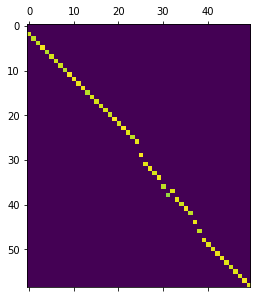

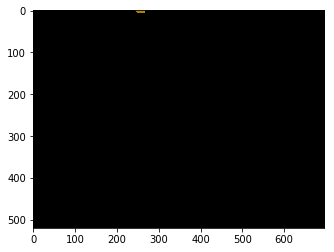

# nuclei ground truth 84
# nuclei model 75
# matches 73
# overdetections 2
# underdetections 11
# mean IoU 0.787522


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P21_s4_w19B7DC88B-10BB-4B51-9A10-9E30285688C1.png is a low contrast image
  warn('%s is a low contrast image' % fname)


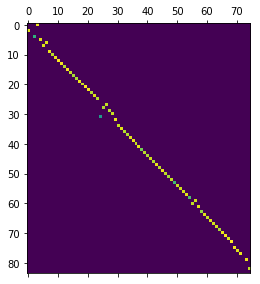

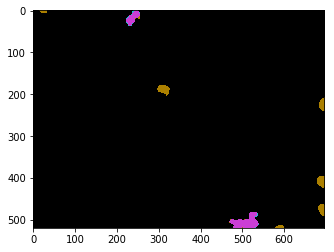

# nuclei ground truth 77
# nuclei model 72
# matches 71
# overdetections 1
# underdetections 6
# mean IoU 0.786871


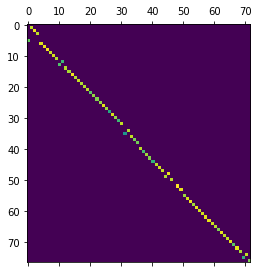

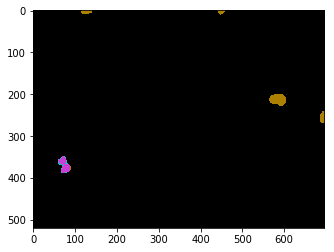

# nuclei ground truth 98
# nuclei model 80
# matches 73
# overdetections 7
# underdetections 25
# mean IoU 0.626691


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P15_s8_w1D26A5BC7-CF59-4027-B785-85AD33773609.png is a low contrast image
  warn('%s is a low contrast image' % fname)


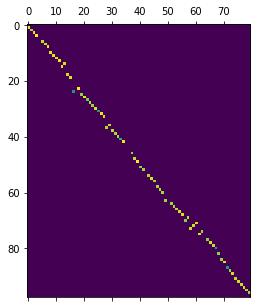

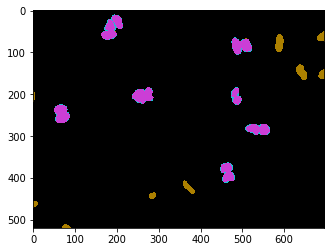

# nuclei ground truth 44
# nuclei model 43
# matches 43
# overdetections 0
# underdetections 1
# mean IoU 0.867381


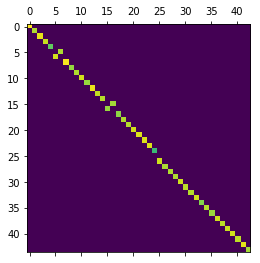

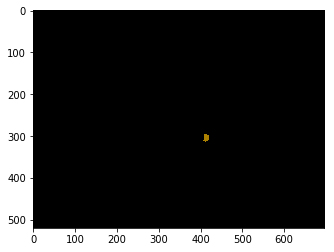

# nuclei ground truth 88
# nuclei model 82
# matches 81
# overdetections 1
# underdetections 7
# mean IoU 0.831115


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_P07_s8_w19D682C29-5685-4A33-8CAA-F0797DD7F021.png is a low contrast image
  warn('%s is a low contrast image' % fname)


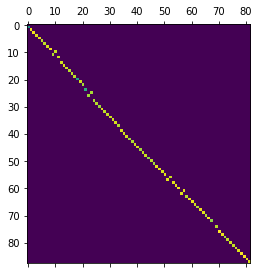

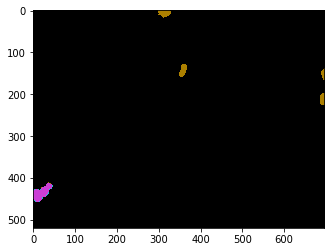

# nuclei ground truth 72
# nuclei model 64
# matches 64
# overdetections 0
# underdetections 8
# mean IoU 0.778587


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_O04_s2_w19A18B0D8-8E8B-4572-A5C0-5C678F3AD54C.png is a low contrast image
  warn('%s is a low contrast image' % fname)


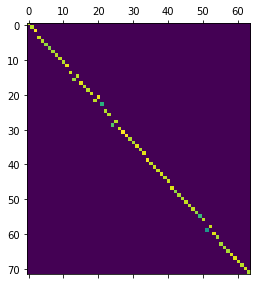

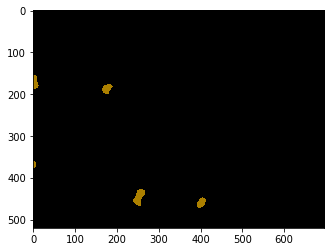

# nuclei ground truth 78
# nuclei model 67
# matches 66
# overdetections 1
# underdetections 12
# mean IoU 0.766334


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_O02_s4_w1814603DA-DD56-44EF-98C5-AFF3B636F986.png is a low contrast image
  warn('%s is a low contrast image' % fname)


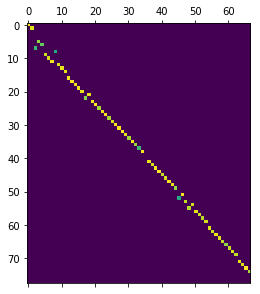

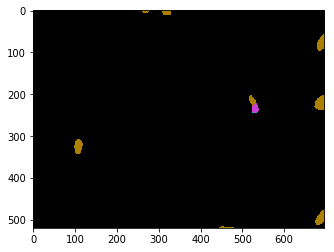

# nuclei ground truth 26
# nuclei model 24
# matches 23
# overdetections 1
# underdetections 3
# mean IoU 0.679589


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_O01_s6_w11A23978B-BAAD-4287-B1F6-FFBCF45C5E2F.png is a low contrast image
  warn('%s is a low contrast image' % fname)


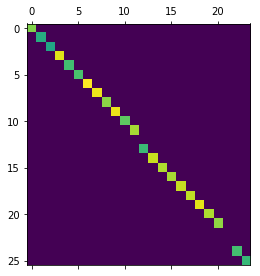

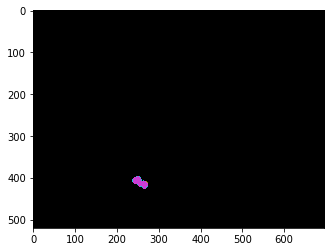

# nuclei ground truth 144
# nuclei model 126
# matches 119
# overdetections 7
# underdetections 25
# mean IoU 0.711808


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_N21_s1_w14F264B20-62D6-47EC-9BCD-B9416AB302D9.png is a low contrast image
  warn('%s is a low contrast image' % fname)


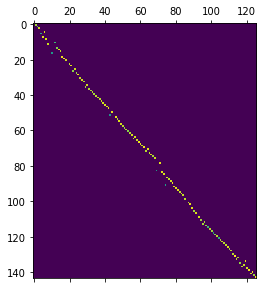

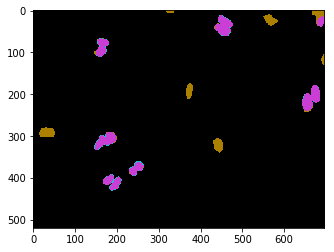

# nuclei ground truth 87
# nuclei model 79
# matches 75
# overdetections 4
# underdetections 12
# mean IoU 0.770746


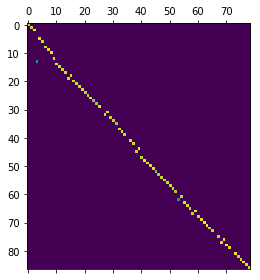

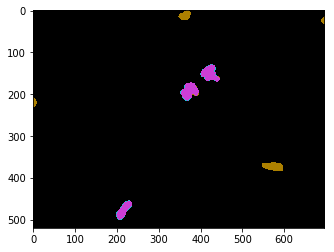

# nuclei ground truth 118
# nuclei model 103
# matches 98
# overdetections 5
# underdetections 20
# mean IoU 0.747381


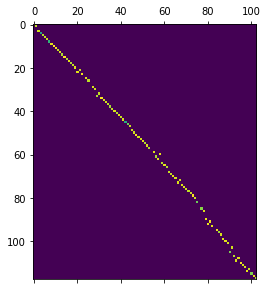

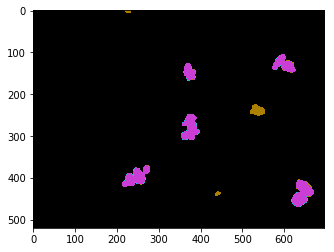

# nuclei ground truth 158
# nuclei model 134
# matches 127
# overdetections 7
# underdetections 31
# mean IoU 0.729576


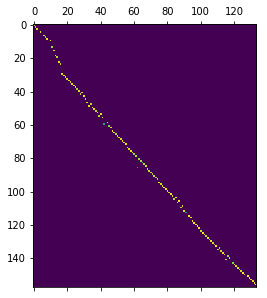

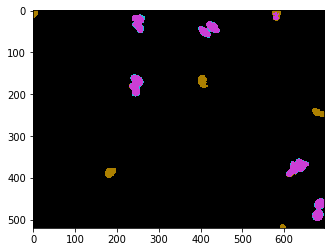

# nuclei ground truth 187
# nuclei model 151
# matches 134
# overdetections 17
# underdetections 53
# mean IoU 0.635862


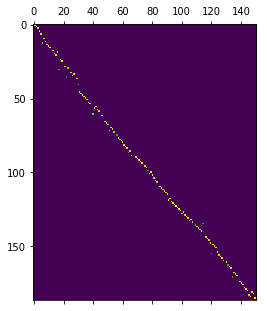

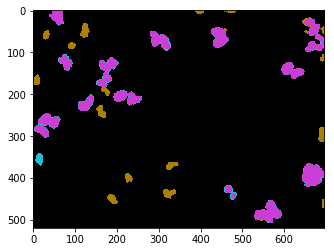

# nuclei ground truth 187
# nuclei model 149
# matches 142
# overdetections 7
# underdetections 45
# mean IoU 0.652415


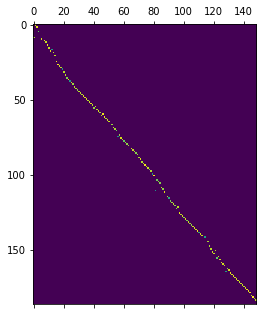

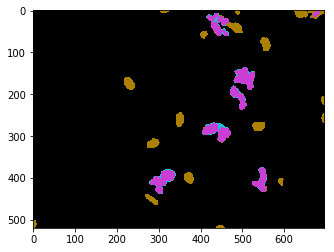

# nuclei ground truth 144
# nuclei model 131
# matches 130
# overdetections 1
# underdetections 14
# mean IoU 0.7898


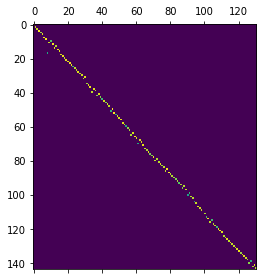

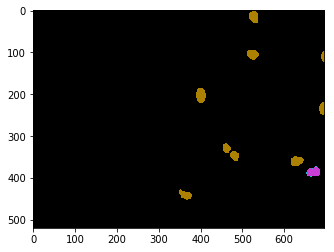

# nuclei ground truth 133
# nuclei model 116
# matches 111
# overdetections 5
# underdetections 22
# mean IoU 0.736858


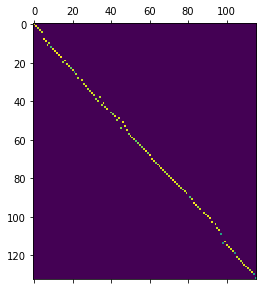

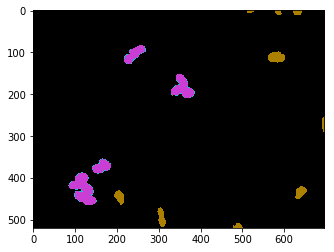

# nuclei ground truth 132
# nuclei model 115
# matches 111
# overdetections 4
# underdetections 21
# mean IoU 0.745146


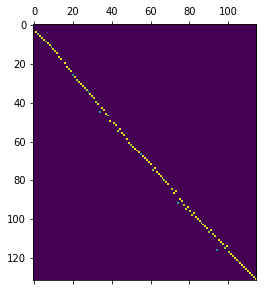

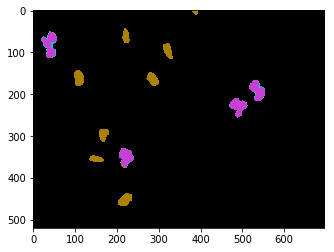

# nuclei ground truth 114
# nuclei model 87
# matches 81
# overdetections 6
# underdetections 33
# mean IoU 0.63263


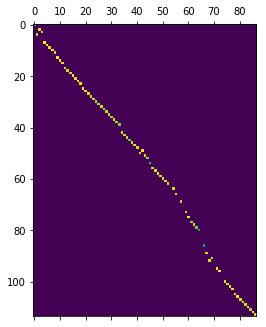

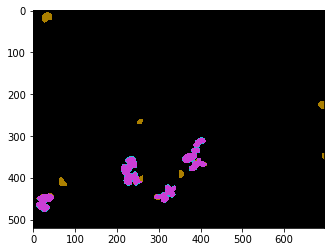

# nuclei ground truth 97
# nuclei model 88
# matches 85
# overdetections 3
# underdetections 12
# mean IoU 0.786075


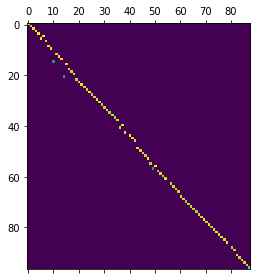

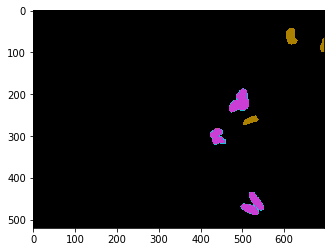

# nuclei ground truth 80
# nuclei model 70
# matches 68
# overdetections 2
# underdetections 12
# mean IoU 0.763399


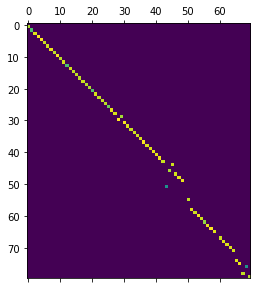

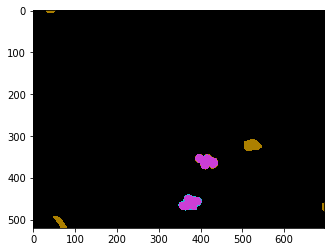

# nuclei ground truth 139
# nuclei model 124
# matches 118
# overdetections 6
# underdetections 21
# mean IoU 0.743793


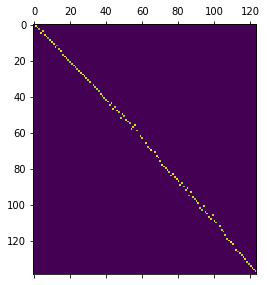

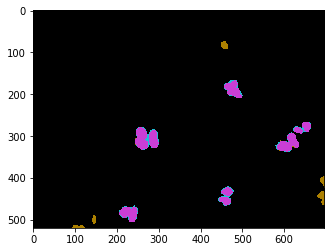

# nuclei ground truth 34
# nuclei model 29
# matches 26
# overdetections 3
# underdetections 8
# mean IoU 0.7025


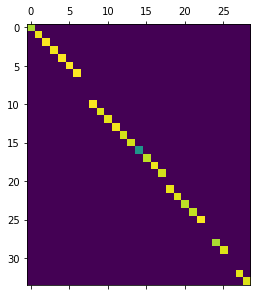

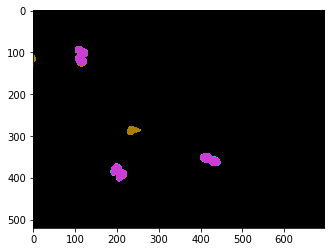

# nuclei ground truth 128
# nuclei model 107
# matches 97
# overdetections 10
# underdetections 31
# mean IoU 0.692811


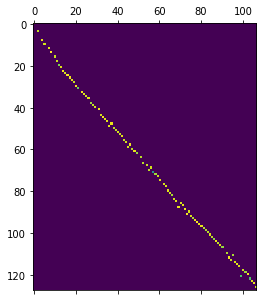

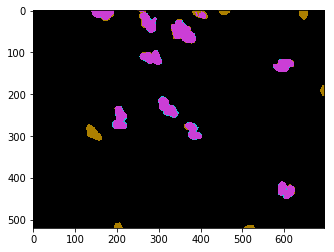

# nuclei ground truth 151
# nuclei model 122
# matches 116
# overdetections 6
# underdetections 35
# mean IoU 0.668004


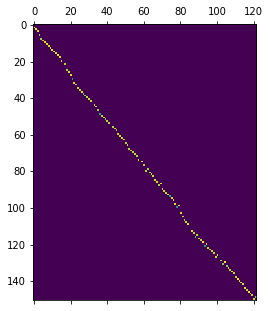

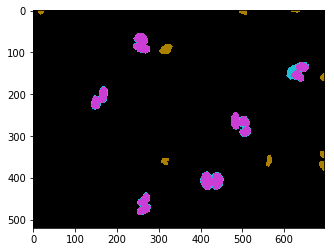

# nuclei ground truth 204
# nuclei model 150
# matches 133
# overdetections 17
# underdetections 71
# mean IoU 0.55533


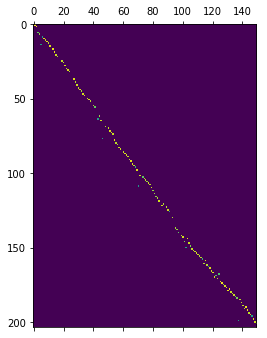

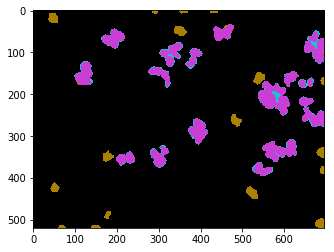

# nuclei ground truth 127
# nuclei model 111
# matches 103
# overdetections 8
# underdetections 24
# mean IoU 0.720461


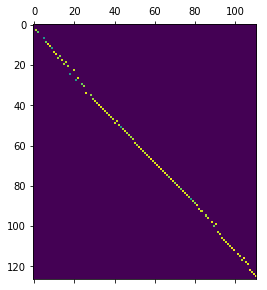

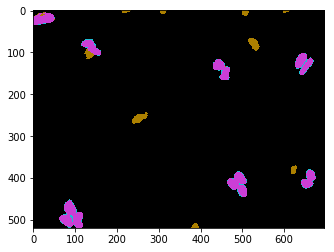

# nuclei ground truth 122
# nuclei model 106
# matches 102
# overdetections 4
# underdetections 20
# mean IoU 0.735865


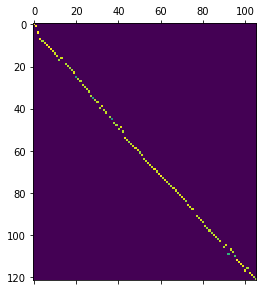

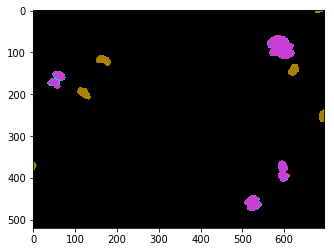

# nuclei ground truth 86
# nuclei model 74
# matches 73
# overdetections 1
# underdetections 13
# mean IoU 0.782919


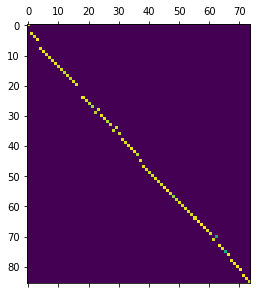

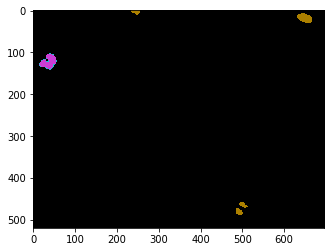

# nuclei ground truth 113
# nuclei model 97
# matches 93
# overdetections 4
# underdetections 20
# mean IoU 0.734814


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_G01_s2_w1FBE52723-8BDF-4346-89BB-216A4A69ED1C.png is a low contrast image
  warn('%s is a low contrast image' % fname)


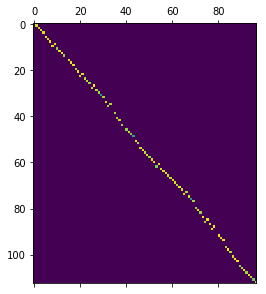

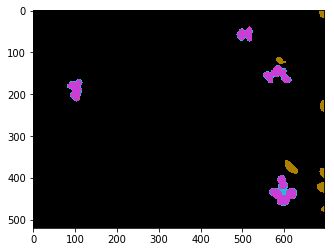

# nuclei ground truth 7
# nuclei model 6
# matches 5
# overdetections 1
# underdetections 2
# mean IoU 0.639778


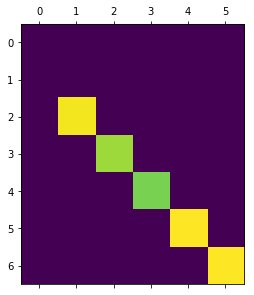

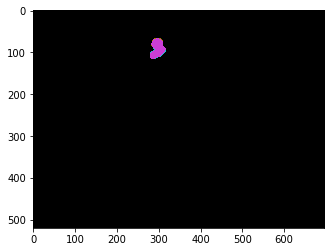

# nuclei ground truth 61
# nuclei model 49
# matches 45
# overdetections 4
# underdetections 16
# mean IoU 0.628234


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_F12_s8_w1DBD80811-5297-4415-ACD1-EC9286BE76A4.png is a low contrast image
  warn('%s is a low contrast image' % fname)


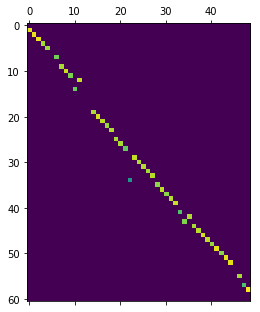

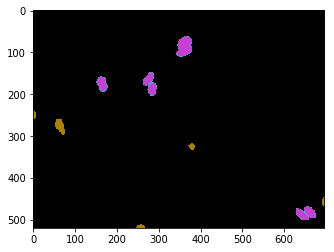

# nuclei ground truth 106
# nuclei model 93
# matches 90
# overdetections 3
# underdetections 16
# mean IoU 0.75095


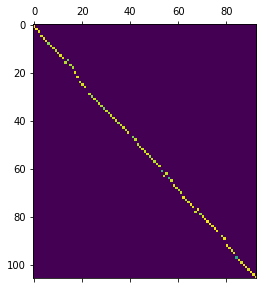

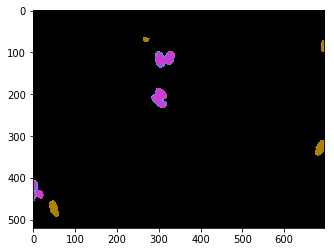

# nuclei ground truth 134
# nuclei model 122
# matches 117
# overdetections 5
# underdetections 17
# mean IoU 0.788224


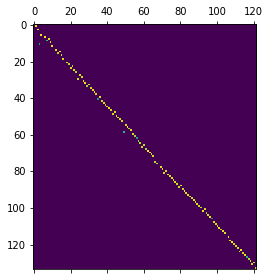

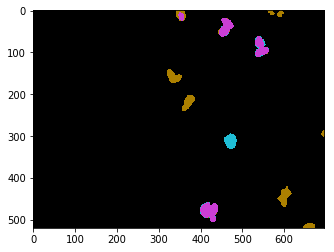

# nuclei ground truth 173
# nuclei model 127
# matches 115
# overdetections 12
# underdetections 58
# mean IoU 0.586212


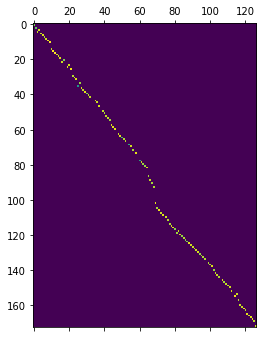

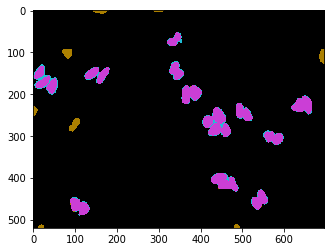

# nuclei ground truth 162
# nuclei model 135
# matches 123
# overdetections 12
# underdetections 39
# mean IoU 0.670015


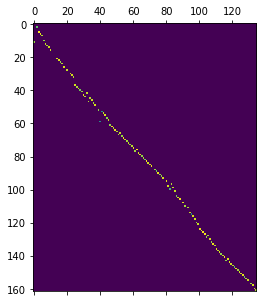

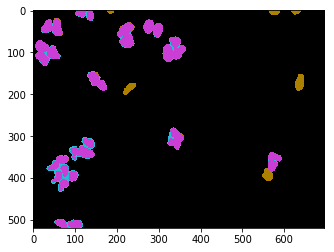

# nuclei ground truth 141
# nuclei model 116
# matches 109
# overdetections 7
# underdetections 32
# mean IoU 0.68756


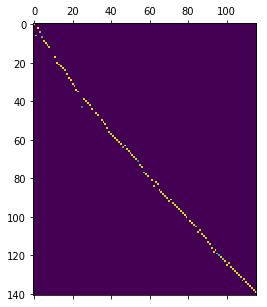

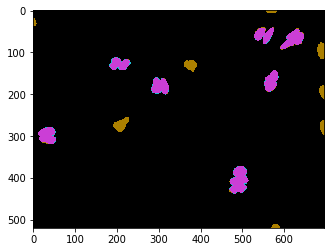

# nuclei ground truth 36
# nuclei model 28
# matches 25
# overdetections 3
# underdetections 11
# mean IoU 0.612166


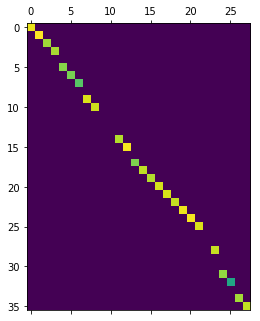

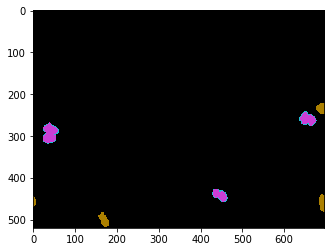

# nuclei ground truth 154
# nuclei model 133
# matches 124
# overdetections 9
# underdetections 30
# mean IoU 0.704172


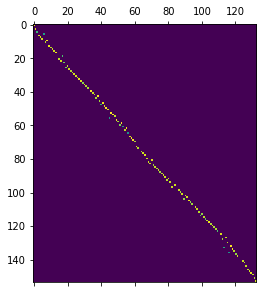

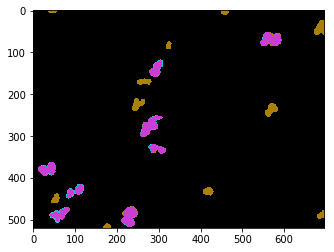

# nuclei ground truth 96
# nuclei model 89
# matches 88
# overdetections 1
# underdetections 8
# mean IoU 0.835224


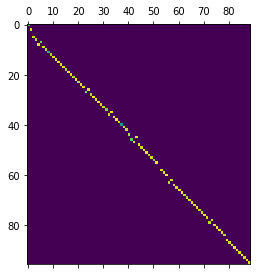

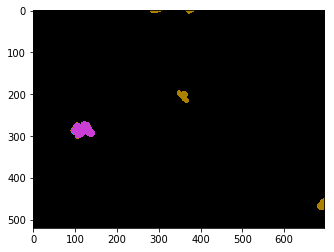

# nuclei ground truth 112
# nuclei model 94
# matches 91
# overdetections 3
# underdetections 21
# mean IoU 0.721476


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_D01_s1_w181AE787C-B5EE-4150-A90E-2FE43165C32E.png is a low contrast image
  warn('%s is a low contrast image' % fname)


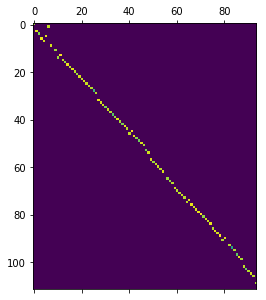

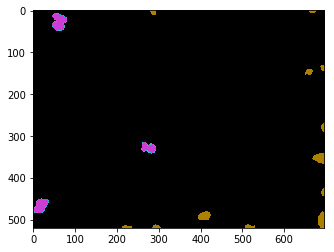

# nuclei ground truth 135
# nuclei model 113
# matches 107
# overdetections 6
# underdetections 28
# mean IoU 0.70823


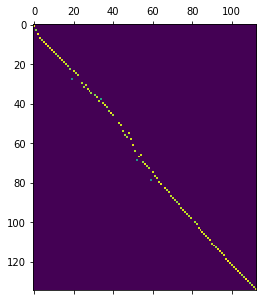

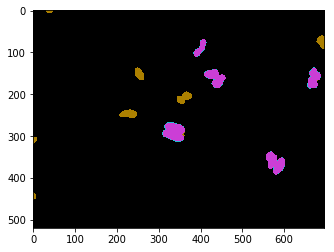

# nuclei ground truth 146
# nuclei model 127
# matches 118
# overdetections 9
# underdetections 28
# mean IoU 0.7359


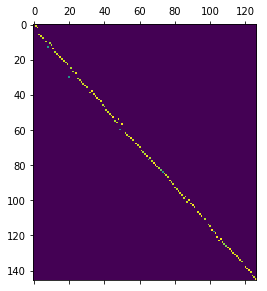

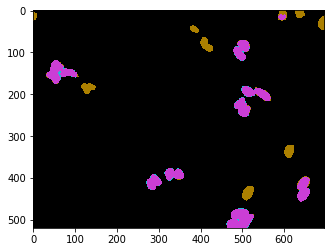

# nuclei ground truth 109
# nuclei model 103
# matches 101
# overdetections 2
# underdetections 8
# mean IoU 0.812713


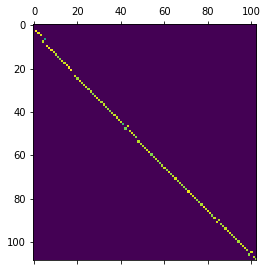

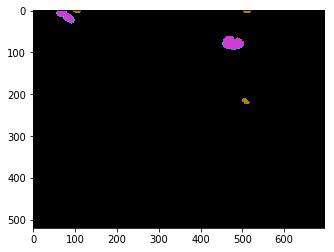

# nuclei ground truth 110
# nuclei model 101
# matches 99
# overdetections 2
# underdetections 11
# mean IoU 0.808761


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_B05_s5_w10296BEF4-0F48-4EC8-BC24-6C604871398B.png is a low contrast image
  warn('%s is a low contrast image' % fname)


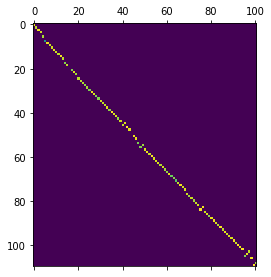

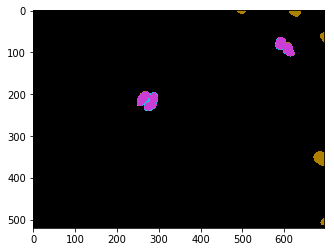

# nuclei ground truth 64
# nuclei model 58
# matches 57
# overdetections 1
# underdetections 7
# mean IoU 0.783272


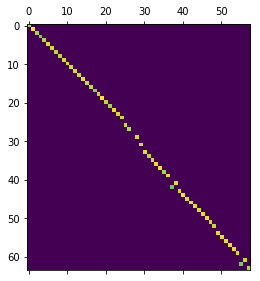

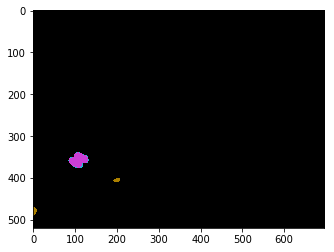

# nuclei ground truth 89
# nuclei model 80
# matches 78
# overdetections 2
# underdetections 11
# mean IoU 0.759976


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_B02_s9_w124B5080D-EBE1-47D2-B147-C0F342039EDF.png is a low contrast image
  warn('%s is a low contrast image' % fname)


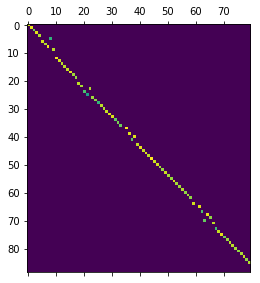

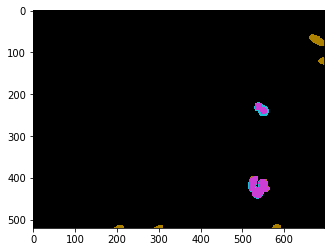

# nuclei ground truth 89
# nuclei model 82
# matches 82
# overdetections 0
# underdetections 7
# mean IoU 0.834744


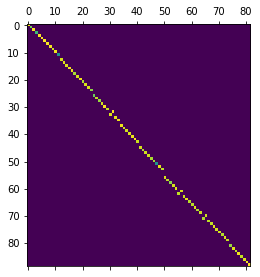

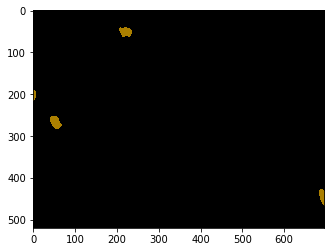

# nuclei ground truth 22
# nuclei model 17
# matches 16
# overdetections 1
# underdetections 6
# mean IoU 0.619223


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_A16_s2_w15AF20A10-82AE-48FA-AC50-7AE8AC3AA544.png is a low contrast image
  warn('%s is a low contrast image' % fname)


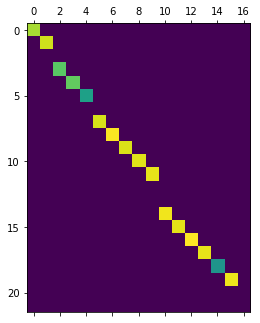

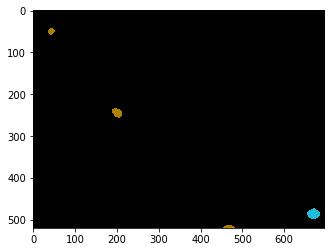

# nuclei ground truth 150
# nuclei model 141
# matches 138
# overdetections 3
# underdetections 12
# mean IoU 0.824939


/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /home/jr0th/github/segmentation/experiments/CP/error_img/IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C.png is a low contrast image
  warn('%s is a low contrast image' % fname)


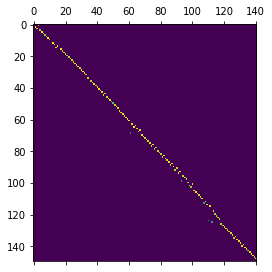

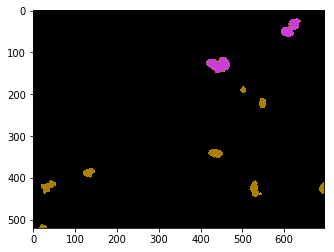

In [5]:
for filename in test_files:
    
    filename_wo_ext = os.path.splitext(filename)[0]
    
    # load error matrices
    IoU = np.load(mat_dir + filename_wo_ext + '.npy')

    # load segmentations
    seg_gt = skimage.io.imread(gt_data_dir + filename)
    seg_mo = skimage.io.imread(mo_data_dir + filename)
    
    # visualize only if matrices are full (no empty images and some detection)
    if(IoU.size != 0):
        error_img = visualize(IoU, seg_gt, seg_mo)
        plt.imshow(error_img)
        plt.show()
        skimage.io.imsave(err_img_out_dir + filename, error_img)
        